In [3]:
%load_ext autoreload
%autoreload 2
from transformers import BertModel, DistilBertModel
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import datasets
import numpy as np
import os.path
from spacy.lang.en import English
from datasets import load_from_disk
import pickle as pkl
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from copy import deepcopy
import torch
from tqdm import tqdm
import dvu
from typing import List
dvu.set_style()
import pandas as pd
from os.path import join as oj
import data
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../experiments')
from auggam import config
pd.set_option('display.max_rows', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# extract the relevant model

In [4]:
cached_model_fname = oj(config.repo_dir, 'results', 'sst_bert_finetuned_ngrams=2.pkl')
row = pkl.load(open(cached_model_fname, "rb"))

# r = data.load_fitted_results(fname_filters=['bert-base', 'sub=-1'], dset_filters=['sst2'])
# row = r[(r.checkpoint == 'textattack/bert-base-uncased-SST-2') & (r.ngrams == 2)].iloc[0]
# row

/home/chansingh/.llm/lib/python3.9/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator LogisticRegressionCV from version 0.24.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## embgam

In [5]:
tokenizer = AutoTokenizer.from_pretrained(row.checkpoint) # for actually passing things to the model
model = AutoModel.from_pretrained(row.checkpoint)
logistic = row.model

seqs = ['not bad', 'not', 'very', 'good', 'not very', 'very good', 'not very good']
device = 'cpu'
tokens = tokenizer(seqs, padding=True, truncation=True, return_tensors="pt").to(device)
model = model.to(device)
with torch.no_grad():
    output = model(**tokens) # has two keys, 'last_hidden_state', 'pooler_output'
embs = output[row.layer].cpu().detach().numpy()
# pkl.dump(embs, open('../results/embs_sst_unigram_bigram.pkl', 'wb'))
scores = embs @ row.model.coef_.T
scores_embgam = {
    seqs[i]: scores[i][0]
    for i in range(len(seqs))
}

Some weights of the model checkpoint at textattack/bert-base-uncased-SST-2 were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# lime

In [113]:
from lime.lime_text import LimeTextExplainer
pipe = pipeline('text-classification', model=row.checkpoint) #, return_all_scores=True)

def pred(x: List) -> np.ndarray:
    # print(x)
    out = pipe(x)
    preds = np.array([d['score'] for d in out]) # for class 1
    preds_proba = np.vstack((preds, 1 - preds)).T
    # print(len(x), preds_proba.shape)
    return preds_proba
pred(['very good', 'not bad', 'excellent']).shape

(3, 2)

In [87]:
class_names = np.array(['negative', 'positive'])
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance('not very good', pred) #, num_features=3)

In [114]:
exp_scores = exp.as_list()

In [115]:
scores_lime = {
    exp_scores[i][0]: exp_scores[i][1]
    for i in range(len(exp_scores))
}

# SHAP

In [149]:
import shap

# load a transformers pipeline model
model = pipeline('text-classification', model=row.checkpoint, return_all_scores=True)

# explain the model on two sample inputs
explainer = shap.Explainer(model, masker = shap.maskers.Text(tokenizer=r"\W+")) 
shap_values = explainer(["not very good"])

`return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.


In [150]:
scores_shap = {
    shap_values[0].data[i]: shap_values[0].values[i][1]
    for i in range(len(shap_values[0].data))
}

# aggregate and viz

In [152]:
scores_all = {
    'embgam': scores_embgam,
    'lime': scores_lime,
    'shap': scores_shap,
}

In [153]:
scores_all

{'embgam': {'not bad': 0.3501985633960234,
  'not': -0.33742450575224603,
  'very': -0.04491109966145235,
  'good': 0.6257117992942993,
  'not very': -1.3865683317300737,
  'very good': 0.7019088348007105,
  'not very good': -1.3237535853206817},
 'lime': {'good': -0.019377856077658535,
  'very': -0.018164648371516778,
  'not': -0.008505737770279818},
 'shap': {'not ': -0.9633358393621165,
  'very ': -0.006509928818559274,
  'good': 0.02823943691328168}}

In [155]:
# pkl.dump(scores_all, open(oj(config.results_dir, 'feat_imp_scores_ex.pkl'), 'wb'))

**Normalize so that all scores are between [-1, 1]**

In [168]:
scores_normed = {}
for k in scores_all:
    vmax = max(np.abs(list(scores_all[k].values())))
    scores_normed[k] = {key: value / vmax for key, value in scores_all[k].items()}
scores_normed

{'embgam': {'not bad': 0.25256495145757973,
  'not': -0.24335223734067887,
  'very': -0.032390109188066535,
  'good': 0.4512664720342885,
  'not very': -1.0,
  'very good': 0.5062201542746273,
  'not very good': -0.9546976914357941},
 'lime': {'good': -1.0,
  'very': -0.9373920571357474,
  'not': -0.4389411158898226},
 'shap': {'not ': -1.0,
  'very ': -0.0067576939967995955,
  'good': 0.029314218115232517}}

In [191]:
cmap = sns.color_palette('vlag_r', as_cmap=True) #20, 220, as_cmap=True, center='light')
import matplotlib

norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

In [194]:
for method in scores_normed:
    print(method)
    for k in scores_normed[method]:
        print('\t', k, matplotlib.colors.rgb2hex(cmap(norm(scores_normed[method][k]))))

embgam
	 not bad #cdd3df
	 not #e8cac8
	 very #faf3f2
	 good #a5b5ce
	 not very #a9373b
	 very good #9aadca
	 not very good #ac3f42
lime
	 good #a9373b
	 very #af4446
	 not #d8a3a0
shap
	 not  #a9373b
	 very  #faf5f4
	 good #f9f5f5


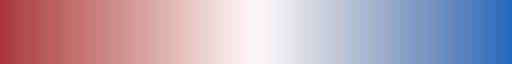

In [195]:
cmap

In [176]:
cmap(1)

(0.7649441118665306, 0.3396246444984717, 0.23152090062227623, 1.0)

In [ ]:
cmap(0)